In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time

## Ridge Regression Using Newton's Method

In [31]:
# Newton's method for ridge regression
def ridge_regression_newton(X, y, lambda_, max_iter=20, tol=1e-6):

    # Start timing
    start_time = time.perf_counter()

    #Initializations
    n_features = X.shape[1]
    beta = np.zeros(n_features)
    convergence = []
    r2_scores = []
    mae_scores = []
    rmse_scores = []

    for iteration in range(max_iter):
        # Calculate predictions
        predictions = X @ beta

        # Compute residuals
        residuals = y - predictions

        # Compute gradient
        gradient = -X.T @ residuals + lambda_ * beta

        # Compute Hessian
        hessian = X.T @ X + lambda_ * np.eye(n_features)

        # Update beta using Newton's method
        beta_update = np.linalg.solve(hessian, gradient) #beta_update = np.linalg.pinv(hessian) @ gradient
        beta -= beta_update

        # Track convergence
        grad_norm = np.linalg.norm(beta_update, ord=2)
        convergence.append(grad_norm)

        # Track metrics
        r2_scores.append(r2_score(y, predictions))
        mae_scores.append(mean_absolute_error(y, predictions))
        rmse_scores.append(np.sqrt(mean_squared_error(y, predictions)))

        # Check for convergence
        if grad_norm < tol:
            print(f"Converged in {iteration} iterations.")
            break
    else:
        print("Newton's Method did not converge within the maximum number of iterations.")

    # Stop timing
    end_time = time.perf_counter()
    time_newton = end_time - start_time

    return beta, convergence, r2_scores, mae_scores, rmse_scores, time_newton

In [32]:
# Closed form solution for ridge regression
def ridge_regression_closed_form(X, y, lambda_):
    # Start timing
    start_time = time.perf_counter()

    n_features = X.shape[1]
    I = np.eye(n_features)
    ret = np.linalg.inv(X.T @ X + lambda_ * I) @ X.T @ y

    # Stop timing
    end_time = time.perf_counter()
    time_closed = end_time - start_time

    return ret, time_closed

## Reading Cleaned Data

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Read in cleaned data
features_train_new = pd.read_csv('/content/drive/MyDrive/X_train.csv')
features_test_new = pd.read_csv('/content/drive/MyDrive/X_test.csv')
labels_train_new = pd.read_csv('/content/drive/MyDrive/y_train.csv')
labels_test_new = pd.read_csv('/content/drive/MyDrive/y_test.csv')

In [35]:
# Drop unnecessary columns
features_train_new.drop(columns=['Unnamed: 0'], inplace=True)
features_test_new.drop(columns=['Unnamed: 0'], inplace=True)
labels_train_new = labels_train_new.drop(columns=['Unnamed: 0'])
labels_test_new = labels_test_new.drop(columns=['Unnamed: 0'])

In [36]:
# Shape of features matrix
np.shape(features_train_new)

(41331, 1254)

In [37]:
# Rank of features matrix
np.linalg.matrix_rank(features_train_new)

1182

Since rank = 1182 < columns = 1254, our features matrix is rank deficient. Perform SVD and only keep the linearly independent columns of our features matrix to ensure we can calculate the inverse of its Hessian later on in Newton's method.

In [38]:
# Perform SVD to remove linearly dependent columns
U, S, Vt = np.linalg.svd(features_train_new, full_matrices=False)

# Reduce the matrix to only the independent columns
rank = np.sum(S > 1e-10)
independent_columns = Vt[:rank, :]
features_train_new_reduced = features_train_new @ independent_columns.T

In [39]:
# Shape of reduced features matrix with only linearly independent columns
np.shape(features_train_new_reduced)

(41331, 1184)

In [40]:
# Extract features (X) and target (y)
X = features_train_new_reduced
y = labels_train_new
y = np.array(y).ravel()

In [41]:
# Normalize columns of X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [42]:
# Add a column of ones to X for the intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])

## Running Newton's Method Ridge Regression

In [43]:
# Set regularization parameter
lambda_ = 1e-6

# Fit the model using Ridge Regression with Newton's Method
beta, convergence, r2_scores, mae_scores, rmse_scores, time_newton = ridge_regression_newton(X, y, lambda_=lambda_)

# Print results
print("Final Coefficients:", beta)
print("Final R^2:", r2_scores[-1])
print("Final MAE:", mae_scores[-1])
print("Final RMSE:", rmse_scores[-1])
print("Execution Time (s):", time_newton)

Newton's Method did not converge within the maximum number of iterations.
Final Coefficients: [ 755929.58409533 -194693.98944172   46393.30847031 ...   -1323.58987018
   -2925.29113065   -5536.63060795]
Final R^2: 0.6354504339693969
Final MAE: 179695.4060014689
Final RMSE: 262443.674796386
Execution Time (s): 60.95683287200018


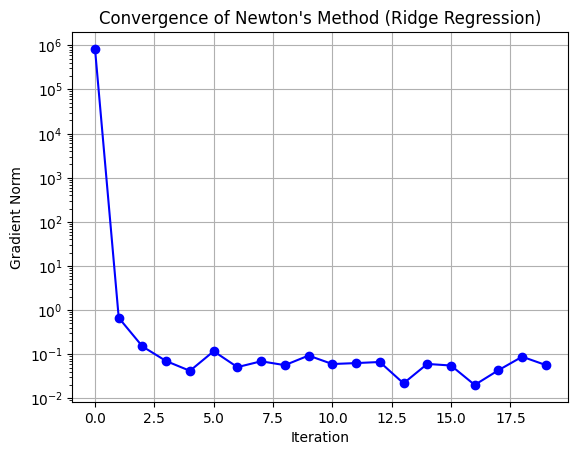

In [44]:
# Plot convergence
plt.figure()
plt.plot(convergence, marker='o', linestyle='-', color='b')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.title('Convergence of Newton\'s Method (Ridge Regression)')
plt.grid(True)
plt.show()

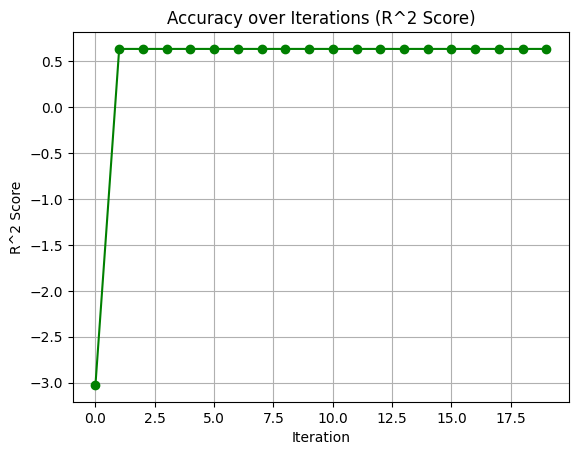

In [45]:
# Plot accuracy
plt.figure()
plt.plot(r2_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Iteration')
plt.ylabel('R^2 Score')
plt.title('Accuracy over Iterations (R^2 Score)')
plt.grid(True)
plt.show()

## Comparing to Closed-Form Solution

In [46]:
# Compute the closed-form solution
beta_closed_form, time_closed = ridge_regression_closed_form(X, y, lambda_)

In [47]:
# Print and compare both solutions
print("Beta from Newton's Method:", beta)
print("Beta from Closed-Form Solution:", beta_closed_form)

# Check the difference
difference = np.linalg.norm(beta - beta_closed_form)
print("Difference between Newton's Method and Closed-Form Solution:", difference)

Beta from Newton's Method: [ 755929.58409533 -194693.98944172   46393.30847031 ...   -1323.58987018
   -2925.29113065   -5536.63060795]
Beta from Closed-Form Solution: [ 755929.58409533 -194693.98943599   46393.30857923 ...   -1323.59192808
   -2925.03214256   -5537.25966315]
Difference between Newton's Method and Closed-Form Solution: 1.1398447813343593


In [48]:
# Compute metrics for Closed-Form Solution
predictions_closed = X @ beta_closed_form
r2_closed = r2_score(y, predictions_closed)

In [49]:
print("Method Comparison:")
print("-------------------------------------------------")
print(f"{'Metric':<20} {'Newton':<15} {'Closed-Form':<15}")
print(f"{'R² Score':<20} {r2_scores[-1]:<15.4f} {r2_closed:<15.4f}")
print(f"{'Execution Time (s)':<20} {time_newton:<15.6f} {time_closed:<15.6f}")

Method Comparison:
-------------------------------------------------
Metric               Newton          Closed-Form    
R² Score             0.6355          0.6355         
Execution Time (s)   60.956833       8.851022       


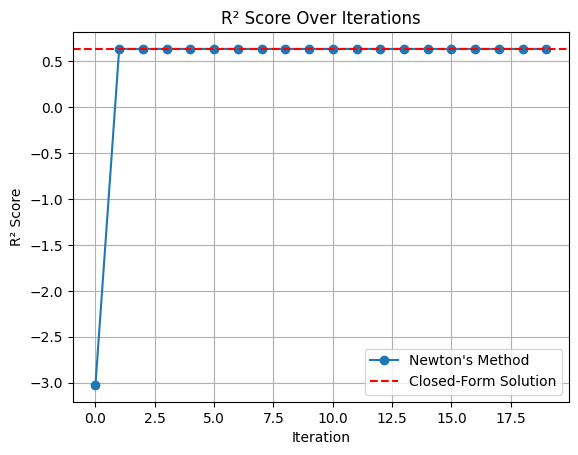

In [50]:
plt.plot(r2_scores, label="Newton's Method", marker='o')
plt.axhline(r2_closed, color='r', linestyle='--', label="Closed-Form Solution")
plt.title("R² Score Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("R² Score")
plt.legend()
plt.grid()
plt.show()

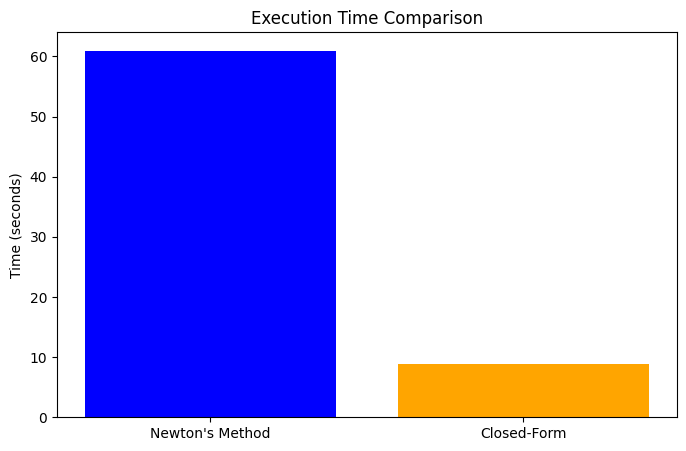

In [51]:
methods = ['Newton\'s Method', 'Closed-Form']
times = [time_newton, time_closed]

plt.figure(figsize=(8, 5))
plt.bar(methods, times, color=['blue', 'orange'])
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()